<a href="https://colab.research.google.com/github/se6-njit/Logistic-Regression-Assignment/blob/main/Logistic_Regression_Assignment_Stephen_Ebrahim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logistic Regression Assignment
##Stephen Ebrahim
##CS 301 - 103

# Part 1: Environment Setup (10 Points)
##Setting up Kaggle API and Fetching data
Initially I will be setting up kaggle which will help me download the dataset. To do this, I have created a ".kaggle" folder in the root directory which will hold the JSON file to my account information. This JSON that I downloaded through my account on kaggle holds my username and API key so that I can actually be able to use the kaggle API/CLI. I also use chmod 600 on the JSON file so that it is not accessible by others. Then I install the kaggle package and through that, I use the CLI to download the dataset. Finally, I unzip the downloaded zipped dataset.

In [21]:
! chmod 600 /root/.kaggle/kaggle.json
! pip install kaggle
! kaggle competitions download -c avazu-ctr-prediction
! unzip avazu-ctr-prediction.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
avazu-ctr-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  avazu-ctr-prediction.zip
replace sampleSubmission.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sampleSubmission.gz     
  inflating: test.gz                 
  inflating: train.gz                


Here is where I access the data I downloaded. I extract the .gz file, and then since the data is extremely large with approximately 4 million records, I will take a random sample of 500,000 thousand records. Of those 500,000 records I will split the training and testing data using the conventional 80-20 split respectively.

In [22]:
import pandas as pd
import gzip
import random

n_records = 4_000_0000  # approximately all records
sample_size = 500_000

with gzip.open('train.gz') as f:
  skipped_records = sorted(random.sample(range(1,n_records), n_records-sample_size))
  df = pd.read_csv(f, skiprows = skipped_records)
  train_df = df.sample(frac=0.8, random_state=301) # random state represents a seed for reproducibility
  test_df = df.drop(train_df.index)

train_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
64129,1.525347e+19,0,14102206,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,...,1,0,19950,320,50,1800,3,167,100079,23
24366,1.537575e+19,0,14102109,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,21725,320,50,2502,0,35,-1,221
595558,4.588907e+18,0,14103020,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22676,320,50,2616,0,35,-1,51
882127,1.725906e+19,0,14103023,1005,0,85f751fd,c4e18dd6,50e219e0,7358e05e,b9528b13,...,1,0,22815,320,50,2647,2,39,100148,23
680909,1.727309e+19,1,14103021,1005,0,6256f5b4,28f93029,f028772b,ecad2386,7801e8d9,...,1,0,23626,320,50,2707,3,937,100156,61


# Part 2: Data Preprocessing (30 points)
## Cleaning Data Using Pandas
In this section, we will be removing the data columns in the training dataset that do not contribute much value in the problem; this addresses noisy and missing/undefined data.



In [23]:
missing_count = train_df.isnull().sum()
missing_df = pd.DataFrame({ 'missing_count' : missing_count})
missing_df.loc[missing_df['missing_count'] > 0]

,missing_count


Since nothing is printed out from this table, this shows that there are no missing or null values. This means that there is nothing to be cleaned out with respect to that.

Next, lets see the uniqueness of each column; the amount of values for each feature will give insight into how this features has an affect. A feature with many values is likely to be some sort of identification and so it is not very easy to deal with to see its affect. On the other hand, if a feature has less values, that might means that those features give a category where each one has a big affect on the situation. This is the thought process and approach I have chosen.

In [24]:
train_df.nunique()

id                  743174
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               2344
site_domain           2384
site_category           22
app_id                2615
app_domain             157
app_category            25
device_id            93390
device_ip           368739
device_model          4725
device_type              4
device_conn_type         4
C14                   2139
C15                      8
C16                      9
C17                    415
C18                      4
C19                     65
C20                    163
C21                     60
dtype: int64

As we can see, id, site_id, site_domain, app_id, app_domain, device_id, device_ip, and device_model are all features with a large number of categories/types, and in my opinion, they are not very relevant data that will cause a big change. I have decided to also leave the anonymized categorical variables (C##) as they are for one, anonymous, and might have a big impact.

Using this information, I will apply Ordinal Encoding on: site_category, and app_category as I believe these will have a large impact on the prediction of the algorithm. Ordinal encoding is when you convert categories in a feature into numbers, for instance ['red', 'blue', 'red'] will be converted into [0, 1, 0].  This makes it easy deal with non numerical inputs in a clever way.

Now, lets import all the needed packages/libraries which are matplotlib and numpy.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import math

Another observation is that the hour is given in the format of YYMMDDHH. And here, I believe the only significant value is the time of day or HH. So I will extract that and insert it in the dataframe instead the current hour format.

In [26]:
(train_df.hour % 100)

64129      6
24366      9
595558    20
882127    23
680909    21
          ..
882216    23
95302     13
498373    18
113589    20
521726    20
Name: hour, Length: 743174, dtype: int64

I will also check if any of the columns have the same value all throughout. This would mean that the feature/column has no impact since the value does not change and thus it would not be an important variable.

In [27]:
def unique_col(s):
  a = s.to_numpy()
  return (a[0] == a).all()

for feature in train_df.columns:
  if unique_col(train_df[feature]):
    print(f'Values all the same for {feature}')

Nothing prints out, meaning all the columns have variety in their values which is good.

Finally, the last thing that I will be doing is normalizing the feature which will limit values to range of [0, 1]. Doing this helps when the magnitude of the features are really large, and it also enhances the performance of the stochastic gradient descent algorithm overall. The formula is for the normalization is as follows

$$x_{normalized-i}=\frac{x_i - x_{min}}{x_{max}-x_{min}}$$

where $x_i$ is an example of the feature $X$.

## Data Preprocessing Function

**This is the function that implements the thought process and discussed things above and will be used on the data to clean up before training.**


In [28]:
def preprocess_data(df):
  # dropping features
  df = df.drop(columns=['id', 'site_id', 'site_domain', 'app_id', 'app_domain', 'device_id', 'device_ip', 'device_model'])
  
  # using Ordinal Encoding
  df.site_category = pd.factorize(df.site_category)[0] 
  df.app_category = pd.factorize(df.app_category)[0]
  
  # formating the date-time into hours --> [0-23]
  df.hour = df.hour % 100

  # normalizing the data between [0, 1]
  for column in df.columns:
    if (column != 'click'):
      den = (df[column].max() - df[column].min())
      if den != 0:
        df[column] = (df[column] - df[column].min()) / den

  # returning the dataframe
  return df

train_df = preprocess_data(train_df)
train_df.head()

,click,hour,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
64129,0,0.260870,0.363636,0.142857,0.000000,0.000000,0.2,0.0,0.826752,0.221239,0.02988,0.637944,1.000000,0.074197,0.998314,0.086614
24366,0,0.391304,0.363636,0.000000,0.047619,0.000000,0.2,0.0,0.901719,0.221239,0.02988,0.903250,0.000000,0.001107,0.000000,0.866142
595558,0,0.869565,0.363636,0.000000,0.047619,0.000000,0.2,0.0,0.941885,0.221239,0.02988,0.946334,0.000000,0.001107,0.000000,0.196850
882127,0,1.000000,0.363636,0.000000,0.095238,0.041667,0.2,0.0,0.947755,0.221239,0.02988,0.958050,0.666667,0.003322,0.999002,0.086614
680909,1,0.913043,0.363636,0.000000,0.000000,0.000000,0.2,0.0,0.982008,0.221239,0.02988,0.980726,1.000000,0.500554,0.999082,0.236220


#Part 3: Logistic Regression (40 points)
Using numpy and pandas, I will use the Stochastic Gradient Decent (SGD) algorithm to solve this regression problem. The formula to minimize is the Mean Squared Error (MSE) Loss function which is defined as the following
$$L(\mathbf w) = \frac{1}{m} \sum_{i=1}^m (\mathbf w^T \mathbf x_i - y_i)^2$$

And its partial derivative is
$$\frac{\partial L(\mathbf w)}{\partial w_j} = \frac{2}{m} \sum_{i=1}^m (\mathbf w^T \mathbf x_i - y_i) x_i^{(j)}$$

Minimizing this will ultimately give us the best parameters for the problem. With each iteration, we update the parameters using the partial derivative of the loss function. For an iteration $i$, the parameter gets update using the following formula
$$w_i = w_i - η∇_w$$
or
$$w_i = w_i - η\left(\frac{2}{m} \sum_{i=1}^m (\mathbf w^T \mathbf x_i - y_i) x_i^{(j)}\right)$$

where $η$ is the learning rate.

It is important that we use the Logistic function, which is essentially a function that takes any input and puts it in a range between (0, 1).

$$f(x)=\frac{1}{1+e^{-x}}$$

where the value of $x$ is the dot product of an example and the $w$ vector. Using this function will in a sense, normalize the predicted value and will allow our predictions to be more accurate.

An optimization that I have done is that I stop the algorithm if the total cost of a certain batch does not change by much from the cost of the previous batch. This means that after a specific iteration, the $w$ vector did not change by an amount that would improve the accuracy of the prediction. I chose this value to be $2$. Moreover, this optimization will account for some of the noise that comes from mini batch stochastic gradient descent. To put this optimization into an equation, it can be represented by the following

$$Improvement = \left|L(w, x_{i-1}-L(w, x_i)\right| < 2$$

where $x_i$ represents a $i^{th}$ batch, $i > 1$, and $w$ represents the vector we are optimizing.

\

Now, we implement the previous fomula in python with the help of numpy and pandas. Since this is a classification problem, we are expecting two outputs: 0 - not clicked, or 1 - clicked. To address this, I will make it so that if the prediction is greater than or equal to a certain threshold, then the prediction will be 1, if its below that threshold, then the prediction will be 0. The value I will use is

$$Threshold = 0.5$$

Note: As mentioned, the logistic function returns a value between the range of (0, 1), and so this threshold is right in the middle of that range.

In [35]:
THRESHOLD = 0.5

# Equation of whats discussed above: used to squish
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

# applying the w vector to an example and getting the prediction
def h(x, w):
  return 1 if float(logistic(np.dot(x, w))) >= THRESHOLD else 0

# will apply the hypothesis to a an array of examples and return the results in an array
def hypothesis_array(X, w):
  predicted = []
  for i in range(len(X)):
    predicted.append(int(h(X[i:i+1], w)))
  return np.array(predicted)

# here we make the step where we move in the direction of the gradient from v
# thus creating the new vector for w
def gradient_step(w, gradient, step_size):
  step = step_size * gradient
  return w + step

# this methods gets the likely hood of an example
def _negative_log_likelihood(x, y, w):
  if y == 1:
    return -math.log(logistic(np.dot(x, w)))
  else:
    return -math.log(1 - logistic(np.dot(x, w)))

# this methods sums up the liklihood of a batch of examples
def negative_log_likelihood(xs, ys, w):
  result = []
  for i in range(len(ys)):
    result.append(_negative_log_likelihood(xs[i:i+1], int(ys[i:i+1]), w))
  return np.sum(result)

# this gets the j-th partial derivative for one example as shown in the formula above
def _negative_log_partial_j(x, y, w, j):
    return -(y - logistic(np.dot(x, w))) * x[j]

# this gets the gradient for one example
def _negative_log_gradient(x, y, w):
  return np.array([_negative_log_partial_j(x.iloc[0], y.iloc[0], w, j) for j in range(len(w))])

# this adds up all the gradients of the batch into one final gradient vector
def negative_log_gradient(xs, ys, w):
  result = np.zeros(len(w))
  for i in range(len(ys)):
    result += _negative_log_gradient(xs[i:i+1], ys[i:i+1], w)
  return result

# mini-batch stochastic gradient descent
def MB_SGD(X, y, w, lr, batch_size, batch_num, epochs):
  # making an array to store the cost history to plot
  L_history = np.array([])

  for epoch in range(epochs):
    batch_L = 0.0 

    # shuffling the data in random order
    indices = np.random.permutation(len(y))
    X = X.iloc[indices]
    y = y.iloc[indices]

    # here we grab a batch to use for the algorithm
    for i in range(0, batch_num * batch_size, batch_size):
      x_batch = X[i:i + batch_size]
      y_batch = y[i:i + batch_size]

      # here we update the w vector using the formula discussed
      gradient = negative_log_gradient(x_batch, y_batch, w)
      w = gradient_step(w, gradient, -lr)

      # adding the cost using formula
      batch_L += negative_log_likelihood(x_batch, y_batch, w)

    # storing the total cost/error for the batch
    L_history = np.append(L_history, batch_L)

    # here is when we make the algorithm more efficient by stopping it if the Cost
    # does not change by much. Here I chose if the absolute value of the 
    # difference between the last two costs is less then 2, then we can stop.
    if len(L_history) > 1 and np.absolute(L_history[epoch-1] - L_history[epoch]) < 2:
      return w, L_history

  return w, L_history

X = train_df.drop(columns=['click']) # here we drop the click column and then use the examples
Y = train_df['click'] # here we store the actual value from the training data after its processed
w = np.zeros(len(X.columns))

learning_rate = 0.001
batch_size = 64
batch_num = 20
epochs = 50
w, L_history = MB_SGD(X, Y, w, learning_rate, batch_size, batch_num, epochs)
w, L_history

(array([-0.21761671, -0.32777212,  0.05523345, -0.07067521, -0.09326229,
        -0.23384841, -0.2554539 , -0.48607298, -0.20739654,  0.07922289,
        -0.42147088, -0.18091866, -0.08740683, -0.36844841, -0.43544003]),
 array([742.56646945, 608.53750103, 582.04431408, 613.62240643,
        598.94891265, 595.18639786, 584.84809714, 617.85983616,
        577.41458287, 581.49096732, 561.35721978, 593.12257136,
        612.83097179, 589.81494685, 628.06515346, 587.48040678,
        601.34990651, 557.18879755, 595.04408039, 576.85166568,
        560.71736417, 588.43355067, 572.86212651, 612.61067738,
        617.94858329, 613.79845977, 588.58394939, 606.3001176 ,
        563.54403535, 572.06119163, 532.03730186, 593.59075113,
        547.12122799, 588.72167816, 585.81101402, 583.66685141,
        611.35092671, 619.34866911, 590.82745933, 598.9799014 ,
        590.26133357, 578.31251982, 591.47465453, 573.85152918,
        629.2563228 , 599.25546725, 586.74700125, 581.08188541,
        587

Now that we have aquired the optimized $w$ vector, we can use it to make predictions. We have also stored the losses in an array and we will plot that to see how the loss has changed over time.

# Part 4: Performance Results (20 points)

First, we will begin by preprocessing the testing data, which is the 20% that I have extracted in the beginning when I loaded the training data.

In [30]:
test_df = preprocess_data(test_df)
test_df

,click,hour,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
7,0,0.0,0.363636,0.000000,0.000000,0.000000,0.2,0.0,0.647210,0.221239,0.02988,0.608466,0.000000,0.001107,0.000000,0.307087
11,1,0.0,0.363636,0.000000,0.000000,0.000000,0.2,0.0,0.647422,0.221239,0.02988,0.608466,0.000000,0.001107,0.000000,0.307087
15,0,0.0,0.363636,0.000000,0.052632,0.047619,0.2,0.0,0.896904,0.221239,0.02988,0.894936,1.000000,0.146179,0.998633,0.236220
21,0,0.0,0.363636,0.000000,0.105263,0.000000,0.2,0.0,0.786333,0.221239,0.02988,0.774376,0.000000,0.001107,0.000000,0.614173
22,0,0.0,0.363636,0.142857,0.157895,0.000000,0.2,0.0,0.819234,0.221239,0.02988,0.799320,0.000000,0.362126,0.998274,0.185039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928916,0,1.0,0.363636,0.000000,0.052632,0.190476,0.2,0.0,0.962326,0.221239,0.02988,0.965608,0.000000,0.007752,0.000000,0.866142
928917,0,1.0,0.363636,0.000000,0.000000,0.000000,0.2,0.0,0.941885,0.221239,0.02988,0.946334,0.000000,0.001107,0.000000,0.196850
928920,0,1.0,0.363636,0.142857,0.157895,0.000000,0.2,0.0,0.733961,0.221239,0.02988,0.710884,0.666667,0.570321,0.000000,0.125984
928944,1,1.0,0.363636,0.142857,0.157895,0.000000,0.2,0.0,0.696161,0.221239,0.02988,0.670824,1.000000,0.003322,0.999511,0.086614


Next we will calculate the error that comes from making our prediction using the optimized $w$ vector.

In [31]:
def mse(X, y):
  predictions = hypothesis_array(X, w)
  actual = np.array(y)
  return np.square(np.subtract(np.array(y), predictions)).mean()

X = test_df.drop(columns=['click']) # here we drop the click column and then use the examples
Y = test_df['click'] # here we store the actual value from the training data after its processed

error = mse(X, Y)
accuracy = 1 - error

print(f'The accuracy of the model is {accuracy}, which means that the error is {error}.')

The accuracy of the model is 0.8267588122265102, which means that the error is 0.17324118777348985.


## Cost/Error Plot of Mini-batch SGD algorithm over Epochs


Min value in error/cost 532.0373018601058


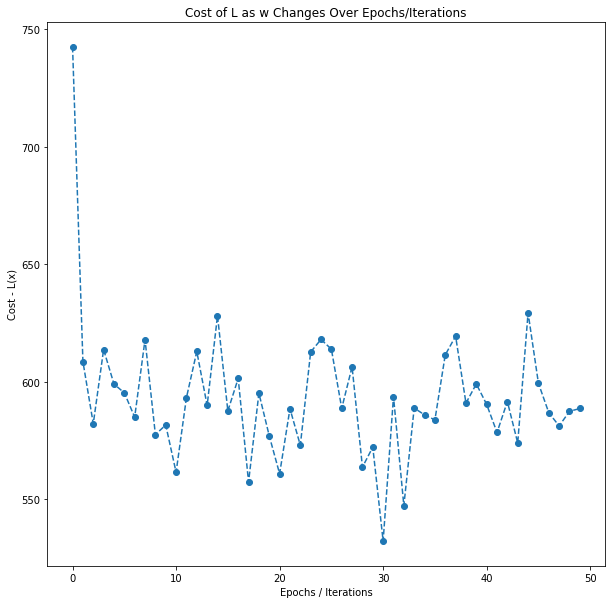

In [36]:
plt.figure(figsize=(10, 10))
plt.plot(range(len(L_history)), L_history, '--o')
print(f'Min value in error/cost {L_history.min()}')
plt.title("Cost of L as w Changes Over Epochs/Iterations")
plt.xlabel('Epochs / Iterations')
plt.ylabel('Cost - L(x)')
plt.show()

This is a perfect plot becuase it proves what we know about the mini-batch stochastic gradient decent algorithm. The error drops quickly, and then the loss value starts increasing and decreasing in a small range, indicating that we have reached the optimal point and we are moving around it.

## Percision-Recall Curve
The equations used here are simple. The equation for Percision is as follows

$$P=\frac{T_p}{T_p + F_p}$$

where $T_p$ is true positive, and $F_p$ is false positive. And the equation for Recall is

$$R=\frac{T_p}{T_p + F_n}$$

where $F_n$ is false negative.

I will apply this formula to the training set and store them in an array then plot the curve.

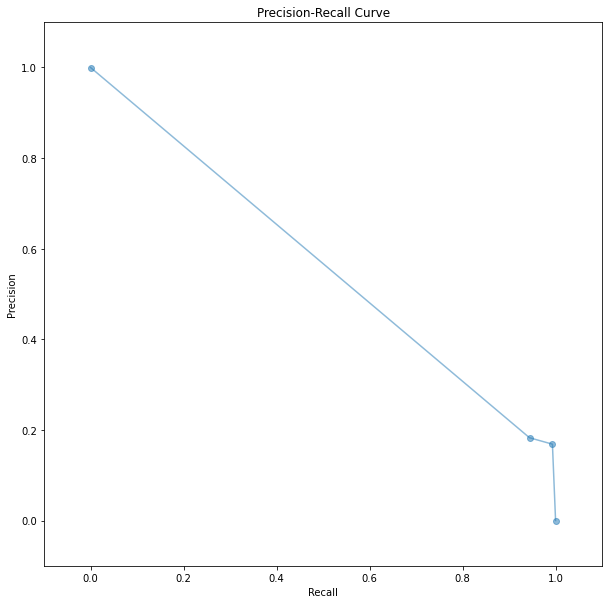

In [37]:
# Precision = True Positives / (True Positives + False Positives)
# Recall = True Positives / (True Positives + False Negatives)

def recall_precision_curve(X, Y, w):
  precision = []
  recall = []
  ths = [.15, .125, .1]
  t = 0
  
  subset = len(Y) // 10
  tp = fp = fn = 0
  for i in range(subset):
    if i % (subset // 4) == 0:
      precision.append(tp / (tp + fp)) if tp + fp > 0 else precision.append(1)
      recall.append(tp / (tp + fn)) if tp + fn > 0 else recall.append(0)
      tp = fp = fn = 0
      t += 1
      if t >= len(ths):
        break

    x = X[i:i+1]
    y = int(Y[i:i+1])
    hyp = 1 if logistic(np.dot(w, X[i:i+1].iloc[0])) >= ths[t] else 0
    if y == 1 and y == hyp:
      tp += 1
    elif y == 1 and hyp == 0:
      fn += 1
    elif y == 0 and hyp == 1:
      fp += 1
    
  precision.append(0)
  recall.append(1)
  return precision, recall

precision, recall = recall_precision_curve(X, Y, w)
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, 'o-', alpha=0.5)
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

## Quanitity Description
Firstly, I will discuss what those quantities mean. True positives mean that the ad is clicked and the function also predicts that the ad was clicked. False positive means that the ad was not clicked, but the function predicts that the ad was clicked. Finally, false negative means that the ad was clicked, but the function predicts that it was not clicked. Precision is a value that describes and is computed only based on the relevancy of the data; for instance, we are looking at cases with 'true' here, so precision will measure how accurate the model is at predicting 'true' or clicked data. On the other hand, recall is a measure of how good the model is at detecting true values.

## Trade-off and Shape of the Curve
These values change as the threshold (which is a value between 0 and 1) changes. For instance, if the threshold is high, that means the function leaves very little room for uncertainty, thus the precision will be high and the recall will be low - the model only predicts 'true' when it is certain. Whereas, if the threshold is low, that means the function/model will be predicting 'true' too often; meaning that the probability of predicting a false negative will be low, implying high recall. This is the tradeoff between those two values; we want the perfect threshold where there is a high value of recall and also a high value of precision.
The perfect shape of the Precision-Recall curve is that of a square, meaning that there is a horizontal line at $precision = 1$ from $recall = [0, 1]$, and a vertical line at $recall = 0$ from $precision = [0, 1]$. The reason it would look like this is that in the perfect scenario, we want maximum recall and precision. In my case, the curve looks like it is a bit higher than a line with the equation $y = -x$. That line is called the baseline; this means that the model that I have is slightly better than the base. The reason that it is only slightly better is that there are a plethora of features to take into consideration, which means that the model would need a more complex training algorithm to be able to perform really well.
